# 模型选择、欠拟合和过拟合

## 基本代码

可以通过多项式拟合来交互地探索这些概念

In [1]:
import math
import numpy as np
import torch
from torch import nn
import d2l_torch as d2l

比如，使用以下三阶多项式来生成训练和测试数据的标签

(**$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2).$$**)

虽然看起来很复杂，但是画到图上，其实还是只有x和y两个数值

In [3]:
max_degree=20
n_train,n_test=100,100
true_w=np.zeros(max_degree)
# 真实权重维度最大为20维
true_w[0:4]=np.array([5,1.2,-3.4,5.6])
# 其中，真实权重的前四个数，也就是上面三阶多项式每一项的系数,后面就都是0

In [20]:
features=np.random.normal(size=(n_train+n_test,1))
# 这里数据特征/随机生成一个数据集，x就是1维的一个数值
np.random.shuffle(features)
# 逐步生成满足要求的数据集，对数据集中每个元素求0-19次方
poly_features=np.power(features,np.arange(max_degree).reshape(1,-1))
# 对每个数据添加噪音,poly_features的shape是(200,20)，200行，20列， 
for i in range(max_degree):
    # 相当于对每个feature的每一项幂次除以对应的阶乘
    poly_features[:,i]/=math.gamma(i+1)

# y=wx(系数乘以x，对应相乘，但是这里x次方截至19）
labels=np.dot(poly_features,true_w)   
# 给y加上噪音 正态分布 loc 均值 scale 偏差
labels+=np.random.normal(scale=0.1,size=labels.shape)

# 可以看到，这里特征和系数，也就是x和w的关系，其实是一个线性模型+噪声

In [22]:
# 再进行一波数据转换
true_w,features,poly_features,labels=[torch.tensor(x,dtype=torch.float32) for x in [true_w,features,poly_features,labels]]

features[:2],poly_features[:2,:],labels[:2]

(tensor([[-0.4982],
         [ 0.9803]]),
 tensor([[ 1.0000e+00, -4.9822e-01,  1.2411e-01, -2.0611e-02,  2.5672e-03,
          -2.5580e-04,  2.1241e-05, -1.5118e-06,  9.4149e-08, -5.2118e-09,
           2.5966e-10, -1.1761e-11,  4.8828e-13, -1.8713e-14,  6.6593e-16,
          -2.2118e-17,  6.8873e-19, -2.0185e-20,  5.5868e-22, -1.4650e-23],
         [ 1.0000e+00,  9.8031e-01,  4.8050e-01,  1.5701e-01,  3.8481e-02,
           7.5446e-03,  1.2327e-03,  1.7263e-04,  2.1154e-05,  2.3041e-06,
           2.2588e-07,  2.0130e-08,  1.6445e-09,  1.2401e-10,  8.6833e-12,
           5.6749e-13,  3.4770e-14,  2.0050e-15,  1.0920e-16,  5.6340e-18]]),
 tensor([4.0847, 5.5315]))

实现一个函数来评估模型在给定数据集上的损失

In [23]:
def evaluate_loss(net,data_iter,loss):
    """
    评估给定数据集模型上的损失
    """
    metric=d2l.Accumulator(2)
    for X,y in data_iter:
        out=net(X)
        y=y.reshape(out.shape)
        l=loss(out,y)
        metric.add(l.sum(),l.numel())
    return metric[0]/metric[1]

定义训练函数

In [24]:
features.shape[-1]
# features的shape是(200,1)

1

先用简单模型拟合，比如用线性模型拟合上面的三阶多项式

In [25]:
def train(train_features,test_features,train_labels,test_labels,num_epochs=400):
    # 定义损失函数
    loss=nn.MSELoss()
    
    # 定义网络
    input_shape=train_features.shape[-1] # 如果使用poly_features 这里input_shape=20
    net=nn.Sequential(nn.Linear(input_shape,1,bias=False))  # 输入维度，输出维度是1，先不要偏置，看看简单模型的拟合效果
    
    # 定义输入数据
    batch_size=min(10,train_labels.shape[0]) # 除了最后一批之外，都是10，最后一批的batch_size可能小于10
    train_iter=d2l.load_array((train_features,train_labels.reshape(-1,1)),batch_size)
    test_iter=d2l.load_array((test_features,test_labels.reshape(-1,1)),batch_size,is_train=False)
    
    # 定义优化器
    trainer=torch.optim.SGD(net.parameters(),lr=0.01) # net只有一层，而且是用sequential定义的
    animator=d2l.Animator(xlabel='epoch',ylabel='loss',yscale="log",xlim=[1,num_epochs],ylim=[1e-3,1e2],legend=['train','test'])
    
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(
                net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())    

先只看样本特征只包含前4项的情况，虽然后面基本都是0+正态分布的噪音。

**首先使用三阶多项式函数，它与数据生成函数的阶数相同，这是模型和数据匹配/符合的情况**
+ 这里的w有四个元素
+ linear的in_features=train_feature.shape[-1]

其实生成labels →y的时候，使用的依然是y=wx+噪声。看看上面造数据部分，所以y和x，也就是labels和poly_features的关系，本来就是线性关系。。

weight: [[ 4.9818106  1.2401378 -3.3559158  5.519681 ]]


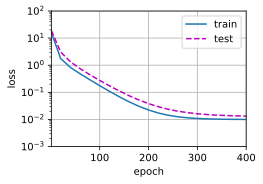

In [26]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4],labels[:n_train], labels[n_train:])

可以看到，最后训练出来的权重，和真实的权重值，差距很小，这里，数据和模型是匹配的。
```python
true_w[0:4]=np.array([5,1.2,-3.4,5.6])
```

线性函数**欠拟合**，只给前两列数据

+ 这里的w只有二个元素
+ 模型容量小（参数少），拟合能力差

weight: [[2.893471  3.4238343]]


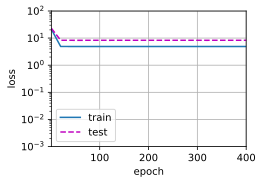

In [27]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2],labels[:n_train], labels[n_train:])

5:02

## 代码解释

In [4]:
x1=np.array([0,1,2])
x2=np.array([1,2,3])
np.power(x1,x2)

array([0, 1, 8], dtype=int32)

np.power这个函数的作用就是把第二个参数作为幂次，作用到第一个参数上，逐元素进行幂次方。所以两个参数的形状必须相同，或者可以通过广播进行运算

In [10]:
a=np.arange(max_degree)
b=np.arange(max_degree).reshape(1,-1)
# 加reshape是为了多一层维度
print(a)
print(b)
print(b.shape)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]]
(1, 20)


In [16]:
print(features.shape)
print(poly_features.shape)
# 200*1  幂次上 1*20 则对features中每个元素，都幂次上max_degree中的20个数字，得到20个结果。
id=2
print(features[id])
print(poly_features[id])
# 可以看到，其实就是对features中的每个元素，找出其0-19次方

(200, 1)
(200, 20)
[-0.75940692]
[ 1.         -0.75940692  0.57669887 -0.43794912  0.33258159 -0.25256476
  0.19179943 -0.14565382  0.11061052 -0.08399839  0.06378896 -0.04844178
  0.03678702 -0.02793632  0.02121503 -0.01611084  0.01223469 -0.00929111
  0.00705573 -0.00535817]


In [19]:
math.gamma(1),math.gamma(2),math.gamma(3),

(1.0, 1.0, 2.0)

这个东西是伽马函数，可以去看看[百度百科的解释](https://baike.baidu.com/item/%E4%BC%BD%E7%8E%9B%E5%87%BD%E6%95%B0/3540177?fromtitle=gamma%E5%87%BD%E6%95%B0&fromid=10819772&fr=aladdin)，伽玛函数（Gamma Function）作为阶乘的延拓，是定义在复数范围内的亚纯函数